In [1]:
import tensorflow as tf

# Check if GPU is available
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        # Set memory growth to avoid allocating all GPU memory at once
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print("GPU is available and memory growth is set.")
    except RuntimeError as e:
        print(e)
else:
    print("No GPU found. Using CPU.")

GPU is available and memory growth is set.


In [2]:
import zipfile
import os

# Download the dataset (if not already attached)
!kaggle datasets download -d skylord/oxbuildings --force

# Extract the dataset
with zipfile.ZipFile('oxbuildings.zip', 'r') as zip_ref:
    zip_ref.extractall('./oxbuildings')

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


Dataset URL: https://www.kaggle.com/datasets/skylord/oxbuildings
License(s): copyright-authors
100%|█████████████████████████████████████▉| 4.28G/4.28G [02:25<00:00, 27.3MB/s]
100%|██████████████████████████████████████| 4.28G/4.28G [02:25<00:00, 31.5MB/s]


In [3]:
import cv2
import numpy as np
import os
import tarfile

def extract_tgz(tgz_path, extract_to):
    # Extract the .tgz file to the specified folder
    with tarfile.open(tgz_path, 'r:gz') as tar:
        tar.extractall(path=extract_to)

def load_images_from_folder(folder, target_size=(128, 128)):
    images = []
    for filename in os.listdir(folder):
        img_path = os.path.join(folder, filename)
        
        # Read the image
        img = cv2.imread(img_path)
        if img is not None:
            # Resize image to target size (if needed)
            img_resized = cv2.resize(img, target_size)
            images.append(img_resized)
    return images

# Path to the .tgz file and extraction folder
tgz_file_path = './oxbuildings/oxbuild_images.tgz'  # Path to your .tgz file
extracted_folder = './oxbuildings/oxbuild_images_extracted'  # Folder where images will be extracted

# Extract images from the .tgz file
extract_tgz(tgz_file_path, extracted_folder)

# Load the images after extraction
clean_images = load_images_from_folder(extracted_folder)

# Convert the list to a NumPy array (optional, if you need it as an array)
clean_images = np.array(clean_images)

print(f"Loaded {len(clean_images)} images.")


Loaded 5063 images.


In [4]:
def add_noise(image, noise_factor=25):
    noise = np.random.normal(0, noise_factor, image.shape).astype(np.uint8)
    noisy_image = cv2.add(image, noise)
    return noisy_image

# Create noisy images
noisy_images = np.array([add_noise(img) for img in clean_images])

In [5]:
!pip install tensorflow keras

In [6]:
from tensorflow.keras import layers, models

def dncnn_model(input_shape):
    model = models.Sequential()
    model.add(layers.Input(shape=input_shape))  # Use Input layer here
    model.add(layers.Conv2D(64, (3, 3), padding='same'))
    model.add(layers.PReLU())
    for _ in range(15):
        model.add(layers.Conv2D(64, (3, 3), padding='same'))
        model.add(layers.PReLU())
    model.add(layers.Conv2D(3, (3, 3), padding='same'))
    return model

# Create the DnCNN model
input_shape = (128, 128, 3)  # Variable input shape
dncnn = dncnn_model(input_shape)

In [7]:
dncnn.compile(optimizer='adam', loss='mean_squared_error')

In [8]:
from sklearn.model_selection import train_test_split

# Resize the images first
clean_images_resized = np.array([cv2.resize(img, (128, 128)) for img in clean_images])
noisy_images_resized = np.array([cv2.resize(img, (128, 128)) for img in noisy_images])

# Normalize and split the dataset
clean_images_normalized = clean_images_resized / 255.0
noisy_images_normalized = noisy_images_resized / 255.0

# Split into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(noisy_images_normalized, clean_images_normalized, test_size=0.2, random_state=42)

print(f"Training set size: {X_train.shape}, Validation set size: {X_val.shape}")


Training set size: (4050, 128, 128, 3), Validation set size: (1013, 128, 128, 3)


In [9]:
history = dncnn.fit(X_train, y_train, epochs=50, batch_size=8, validation_data=(X_val, y_val))

Epoch 1/50


I0000 00:00:1736880865.328542     101 service.cc:145] XLA service 0x7be80c0015a0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1736880865.328604     101 service.cc:153]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0


  3/507 ━━━━━━━━━━━━━━━━━━━━ 30s 61ms/step - loss: 0.5684 

I0000 00:00:1736880869.603638     101 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


507/507 ━━━━━━━━━━━━━━━━━━━━ 45s 70ms/step - loss: 0.0867 - val_loss: 0.0137
Epoch 2/50
507/507 ━━━━━━━━━━━━━━━━━━━━ 31s 61ms/step - loss: 0.0115 - val_loss: 0.0094
Epoch 3/50
507/507 ━━━━━━━━━━━━━━━━━━━━ 31s 62ms/step - loss: 0.0081 - val_loss: 0.0082
Epoch 4/50
507/507 ━━━━━━━━━━━━━━━━━━━━ 32s 63ms/step - loss: 0.0060 - val_loss: 0.0060
Epoch 5/50
507/507 ━━━━━━━━━━━━━━━━━━━━ 31s 62ms/step - loss: 0.0058 - val_loss: 0.0055
Epoch 6/50
507/507 ━━━━━━━━━━━━━━━━━━━━ 31s 61ms/step - loss: 0.0052 - val_loss: 0.0049
Epoch 7/50
507/507 ━━━━━━━━━━━━━━━━━━━━ 31s 62ms/step - loss: 0.0049 - val_loss: 0.0075
Epoch 8/50
507/507 ━━━━━━━━━━━━━━━━━━━━ 31s 62ms/step - loss: 0.0049 - val_loss: 0.0048
Epoch 9/50
507/507 ━━━━━━━━━━━━━━━━━━━━ 31s 62ms/step - loss: 0.0044 - val_loss: 0.0045
Epoch 10/50
507/507 ━━━━━━━━━━━━━━━━━━━━ 32s 62ms/step - loss: 0.0042 - val_loss: 0.0054
Epoch 11/50
507/507 ━━━━━━━━━━━━━━━━━━━━ 32s 63ms/step - loss: 0.0045 - val_loss: 0.0043
Epoch 12/50
507/507 ━━━━━━━━━━━━━━━━━━━━ 

In [11]:
# Save the model
dncnn.save('dncnn_model_epoch_40.h5')


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 645ms/step


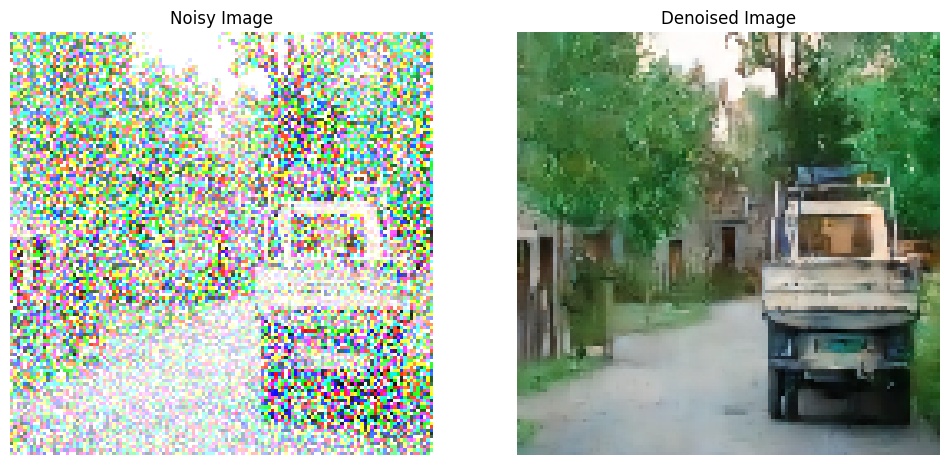

In [12]:
# Step 8: Evaluate the Model
# Denoise a sample image from the validation set
sample_noisy_image = X_val[0]  # Take the first noisy image from the validation set
denoised_image = dncnn.predict(np.expand_dims(sample_noisy_image, axis=0))[0]  # Predict denoised image

# Step 9: Visualize the Results
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(sample_noisy_image)
plt.title('Noisy Image')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(denoised_image)
plt.title('Denoised Image')
plt.axis('off')

plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


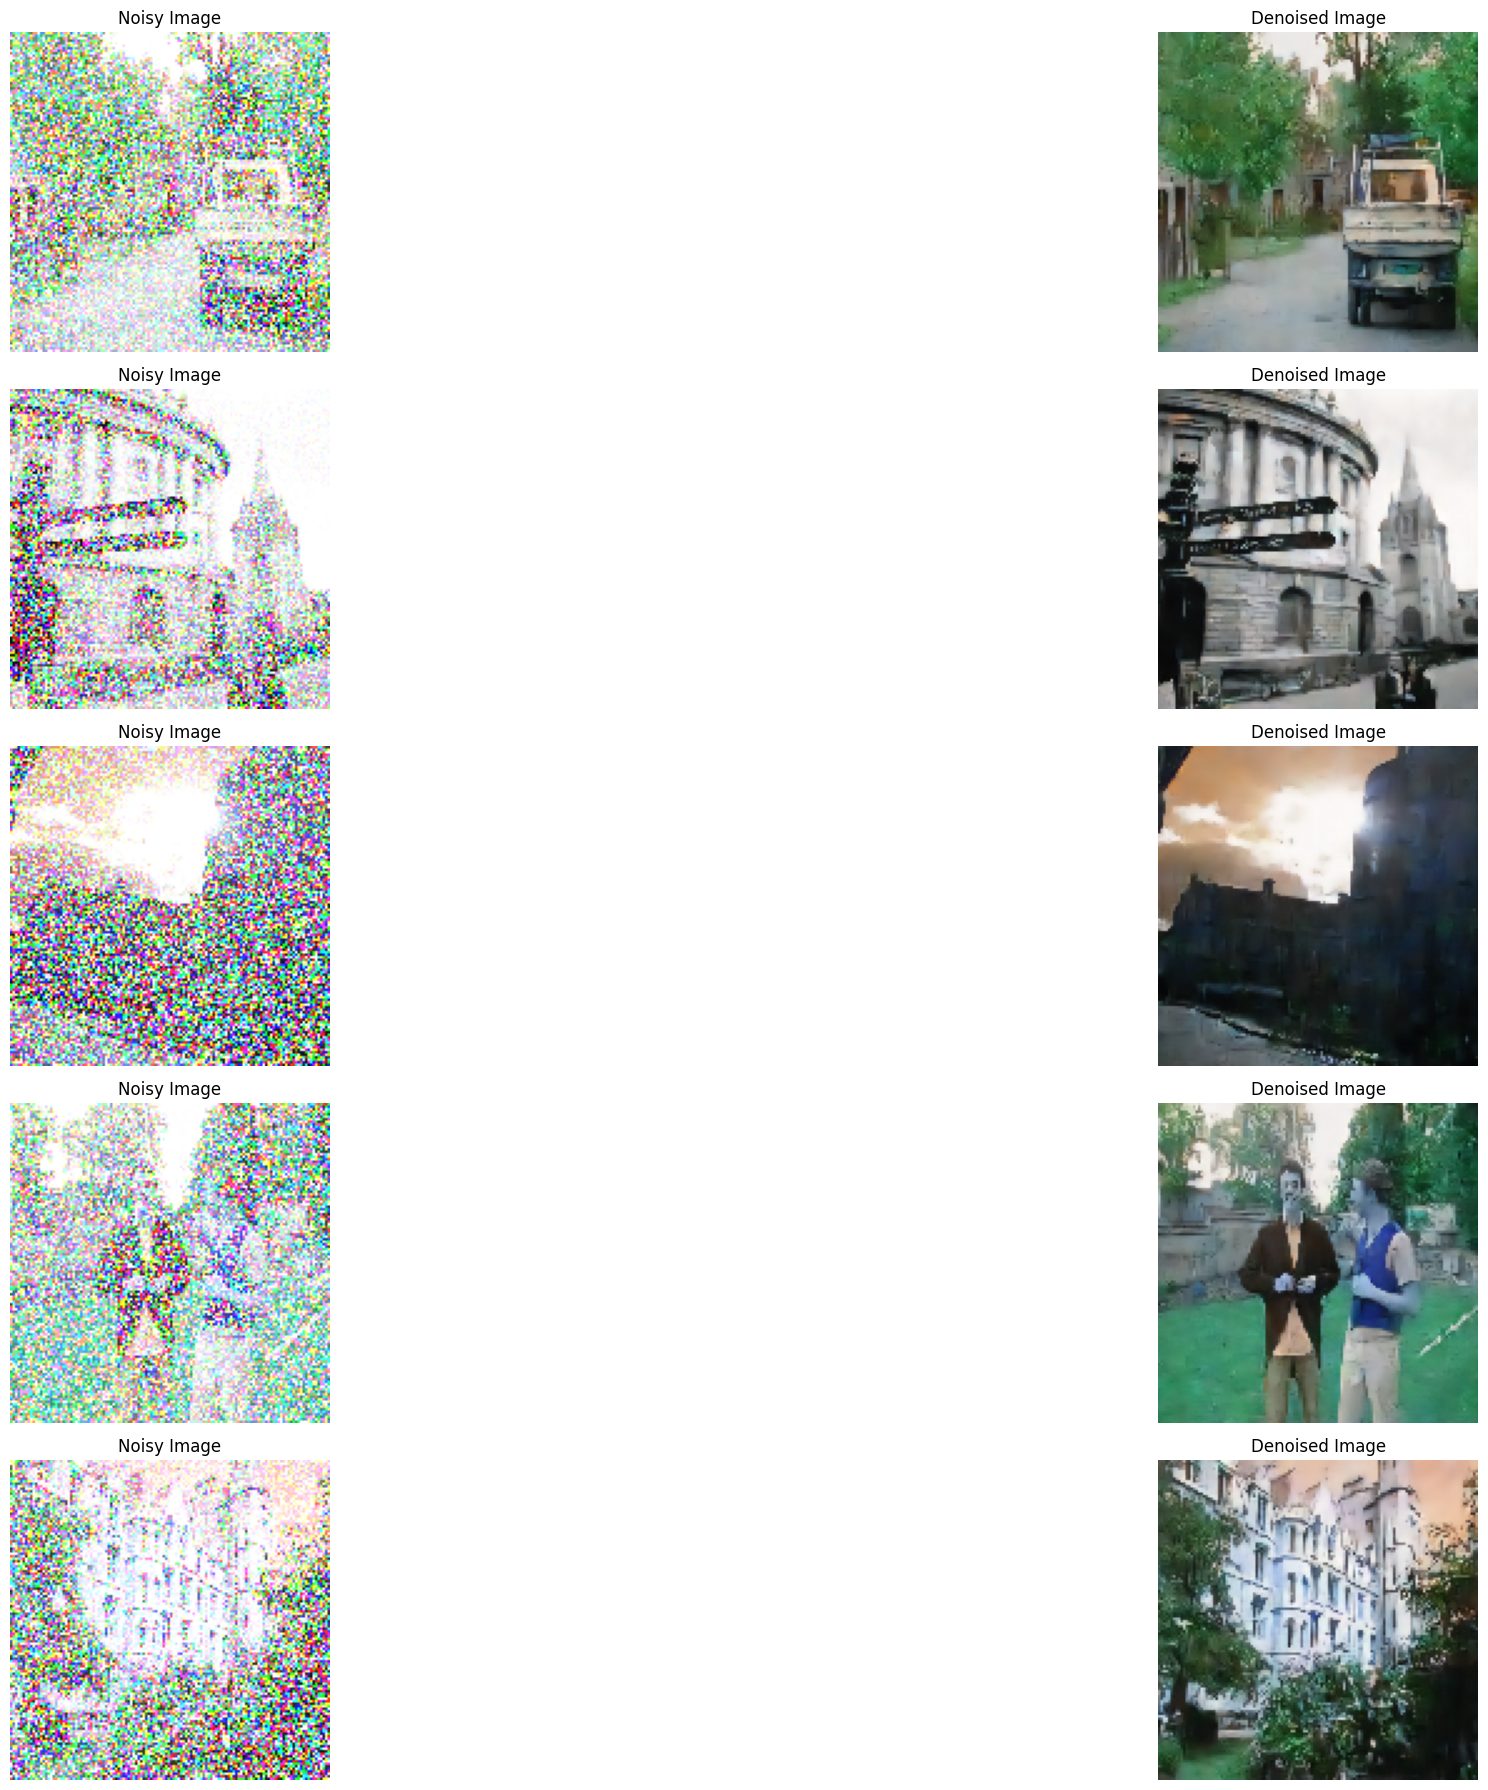

In [14]:
import numpy as np
import matplotlib.pyplot as plt

# Function to visualize denoising results
def visualize_denoising(X_val, model, num_samples=5):
    plt.figure(figsize=(32, 18))
    
    for i in range(num_samples):
        sample_noisy_image = X_val[i]  # Take the i-th noisy image from the validation set
        denoised_image = model.predict(np.expand_dims(sample_noisy_image, axis=0))[0]  # Predict denoised image
        
        # Normalize images for display
        sample_noisy_image = (sample_noisy_image - np.min(sample_noisy_image)) / (np.max(sample_noisy_image) - np.min(sample_noisy_image))
        denoised_image = (denoised_image - np.min(denoised_image)) / (np.max(denoised_image) - np.min(denoised_image))
        
        plt.subplot(num_samples, 2, 2*i + 1)
        plt.imshow(sample_noisy_image, cmap='gray')  # Use cmap='gray' for grayscale images
        plt.title('Noisy Image')
        plt.axis('off')

        plt.subplot(num_samples, 2, 2*i + 2)
        plt.imshow(denoised_image, cmap='gray')
        plt.title('Denoised Image')
        plt.axis('off')

    plt.tight_layout()
    plt.show()

# Call the function to visualize results
visualize_denoising(X_val, dncnn, num_samples=5)

KeyError: 'accuracy'

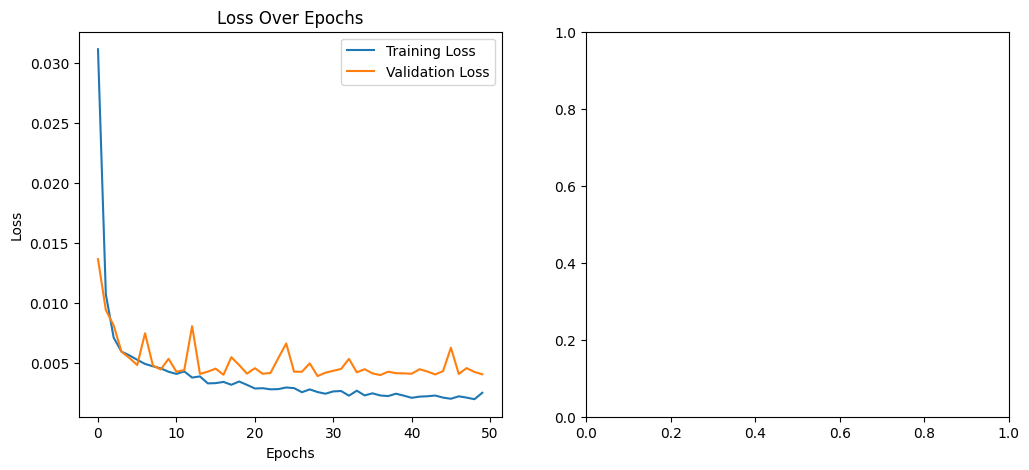

In [15]:
# Step 10: Plot Training History
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy Over Epochs')
plt.xlabel('Epochs')
plt.legend()

plt.show()

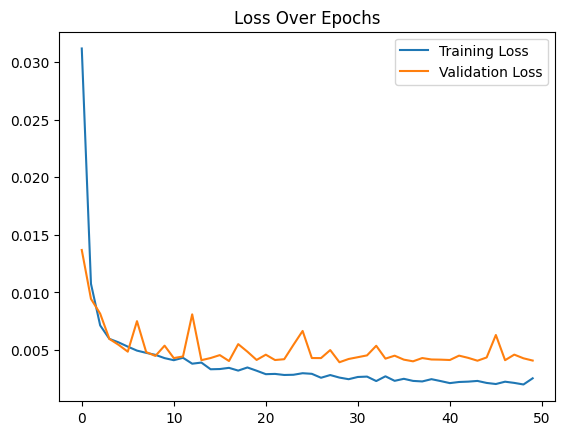

In [16]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Over Epochs')
plt.legend()
plt.show()


In [17]:
def calculate_ssim(original, denoised, win_size=3, data_range=255):
    """Calculate Structural Similarity Index (SSIM) with a specified window size and data range"""
    return ssim(original, denoised, multichannel=True, win_size=win_size, data_range=data_range)

# Example usage
# Assuming you have a sample noisy image and its corresponding clean image
sample_noisy_image = X_val[0]  # Noisy image
sample_clean_image = y_val[0]  # Clean image (ground truth)

# Denoise the sample noisy image
denoised_image = dncnn.predict(np.expand_dims(sample_noisy_image, axis=0))[0]

# Calculate metrics
mse_value = calculate_mse(sample_clean_image, denoised_image)
psnr_value = calculate_psnr(sample_clean_image, denoised_image)
ssim_value = calculate_ssim(sample_clean_image, denoised_image, win_size=3, data_range=255)  # Specify data range

# Print the evaluation metrics
print(f'Mean Squared Error (MSE): {mse_value:.4f}')
print(f'Peak Signal-to-Noise Ratio (PSNR): {psnr_value:.4f} dB')
print(f'Structural Similarity Index (SSIM): {ssim_value:.4f}')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


NameError: name 'calculate_mse' is not defined

In [18]:
import numpy as np
from skimage.metrics import structural_similarity as ssim

# Define calculate_mse
def calculate_mse(original, denoised):
    """Calculate Mean Squared Error (MSE)"""
    return np.mean((original - denoised) ** 2)

# Define calculate_psnr
def calculate_psnr(original, denoised, data_range=255):
    """Calculate Peak Signal-to-Noise Ratio (PSNR)"""
    mse = calculate_mse(original, denoised)
    if mse == 0:
        return float('inf')  # Avoid log of zero
    return 20 * np.log10(data_range / np.sqrt(mse))

# Define calculate_ssim
def calculate_ssim(original, denoised, win_size=3, data_range=255):
    """Calculate Structural Similarity Index (SSIM) with a specified window size and data range"""
    return ssim(original, denoised, multichannel=True, win_size=win_size, data_range=data_range)

# Example usage
# Assuming you have a sample noisy image and its corresponding clean image
sample_noisy_image = X_val[0]  # Noisy image
sample_clean_image = y_val[0]  # Clean image (ground truth)

# Denoise the sample noisy image
denoised_image = dncnn.predict(np.expand_dims(sample_noisy_image, axis=0))[0]

# Calculate metrics
mse_value = calculate_mse(sample_clean_image, denoised_image)
psnr_value = calculate_psnr(sample_clean_image, denoised_image, data_range=255)
ssim_value = calculate_ssim(sample_clean_image, denoised_image, win_size=3, data_range=255)

# Print the evaluation metrics
print(f'Mean Squared Error (MSE): {mse_value:.4f}')
print(f'Peak Signal-to-Noise Ratio (PSNR): {psnr_value:.4f} dB')
print(f'Structural Similarity Index (SSIM): {ssim_value:.4f}')


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Mean Squared Error (MSE): 0.0045
Peak Signal-to-Noise Ratio (PSNR): 71.6084 dB
Structural Similarity Index (SSIM): 0.9998


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 754ms/step


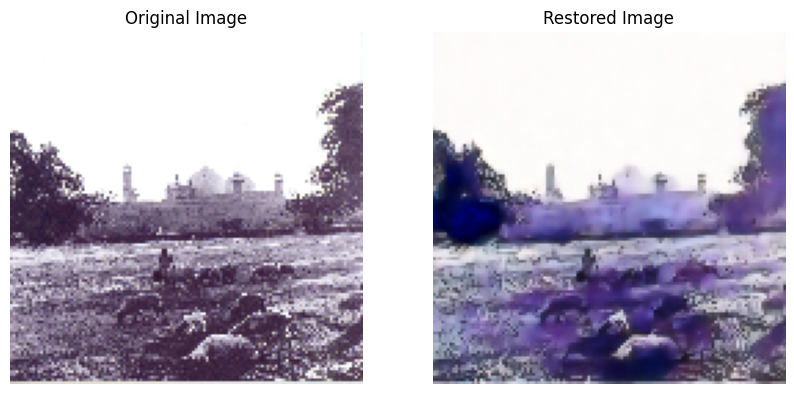

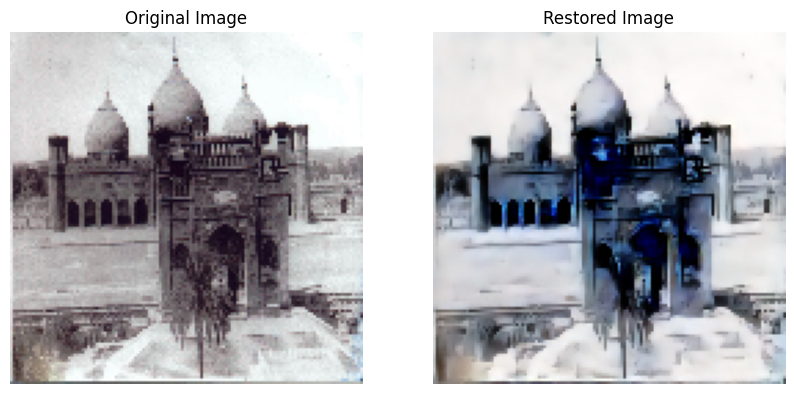

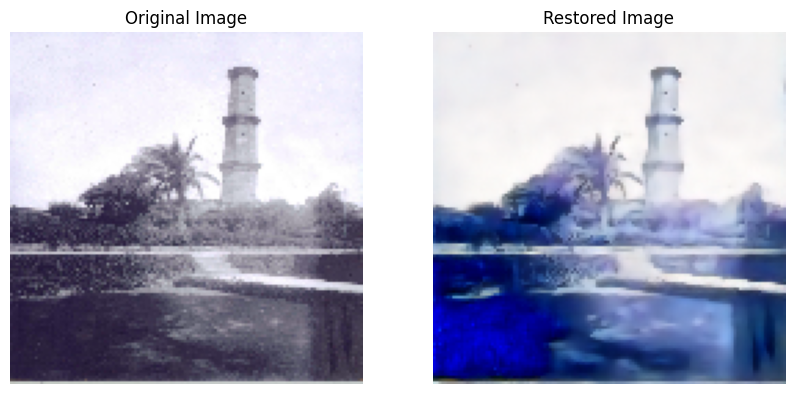

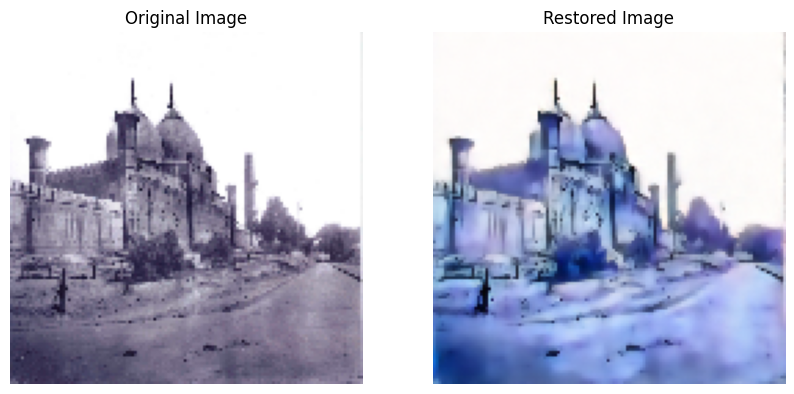

In [19]:
import cv2
import numpy as np
import os
import matplotlib.pyplot as plt

# Function to load custom images from a folder
def load_custom_images(folder, size=(128, 128)):
    images = []
    for filename in os.listdir(folder):
        img = cv2.imread(os.path.join(folder, filename))
        if img is not None:
            img_resized = cv2.resize(img, size)  # Resize to the target size
            images.append(img_resized)
    return np.array(images)

# Path to your custom images
custom_images_folder = '/kaggle/input/testing123'  # Update this path
custom_images = load_custom_images(custom_images_folder)

# Normalize the images if your model requires it
custom_images_normalized = custom_images / 255.0  # Assuming your model expects [0, 1] range

# Denoise the custom images using your trained model
denoised_images = dncnn.predict(custom_images_normalized)

# Visualize the results
for i in range(len(custom_images)):
    plt.figure(figsize=(10, 5))
    
    # Original image
    plt.subplot(1, 2, 1)
    plt.imshow(custom_images[i] / 255.0)  # Display original image
    plt.title('Original Image')
    plt.axis('off')
    
    # Denoised image
    plt.subplot(1, 2, 2)
    plt.imshow(denoised_images[i])  # Display denoised image
    plt.title('Restored Image')
    plt.axis('off')
    
    plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
Mean Squared Error (MSE): 0.0045
Peak Signal-to-Noise Ratio (PSNR): 71.6084 dB
Structural Similarity Index (SSIM): 0.9998


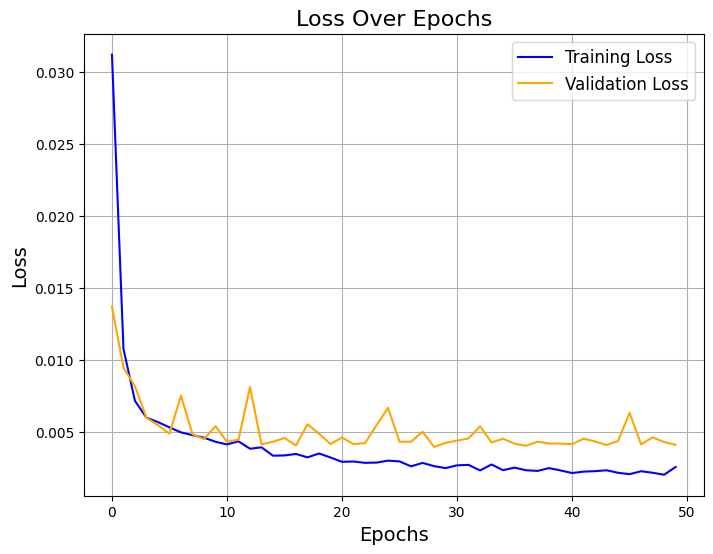

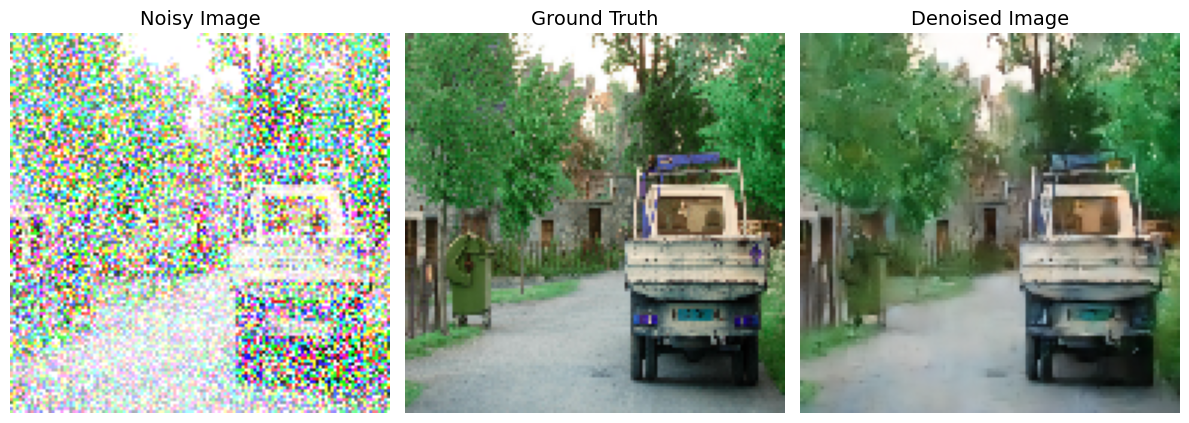

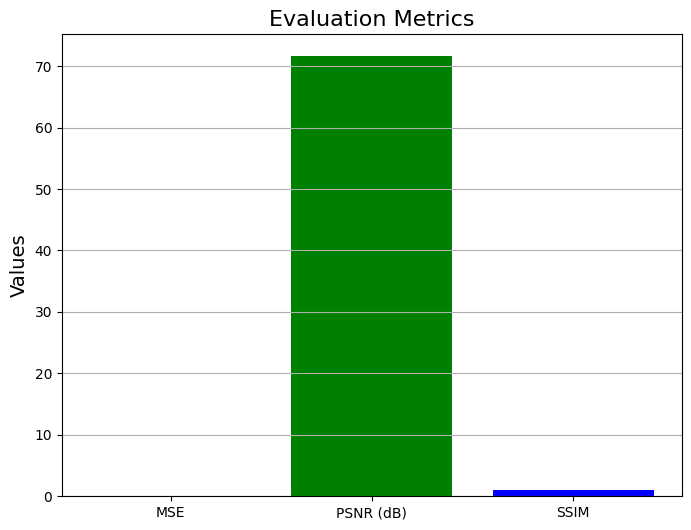

In [20]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.metrics import structural_similarity as ssim

# Define the metric functions
def calculate_mse(original, denoised):
    """Calculate Mean Squared Error (MSE)"""
    return np.mean((original - denoised) ** 2)

def calculate_psnr(original, denoised, data_range=255):
    """Calculate Peak Signal-to-Noise Ratio (PSNR)"""
    mse = calculate_mse(original, denoised)
    if mse == 0:
        return float('inf')  # Avoid log of zero
    return 20 * np.log10(data_range / np.sqrt(mse))

def calculate_ssim(original, denoised, win_size=3, data_range=255):
    """Calculate Structural Similarity Index (SSIM)"""
    return ssim(original, denoised, multichannel=True, win_size=win_size, data_range=data_range)

# Plot Loss Curves
def plot_loss(history):
    """Plot Training and Validation Loss"""
    plt.figure(figsize=(8, 6))
    plt.plot(history.history['loss'], label='Training Loss', color='blue')
    plt.plot(history.history['val_loss'], label='Validation Loss', color='orange')
    plt.title('Loss Over Epochs', fontsize=16)
    plt.xlabel('Epochs', fontsize=14)
    plt.ylabel('Loss', fontsize=14)
    plt.legend(fontsize=12)
    plt.grid(True)
    plt.show()

# Visualize Denoising Results
def plot_denoising_results(noisy_image, clean_image, denoised_image):
    """Visualize Noisy, Clean (Ground Truth), and Denoised Images"""
    plt.figure(figsize=(12, 8))

    plt.subplot(1, 3, 1)
    plt.imshow(noisy_image, cmap='gray')
    plt.title('Noisy Image', fontsize=14)
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.imshow(clean_image, cmap='gray')
    plt.title('Ground Truth', fontsize=14)
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.imshow(denoised_image, cmap='gray')
    plt.title('Denoised Image', fontsize=14)
    plt.axis('off')

    plt.tight_layout()
    plt.show()

# Bar Plot for Evaluation Metrics
def plot_metrics(mse_value, psnr_value, ssim_value):
    """Plot Bar Graph for MSE, PSNR, and SSIM"""
    metrics = ['MSE', 'PSNR (dB)', 'SSIM']
    values = [mse_value, psnr_value, ssim_value]

    plt.figure(figsize=(8, 6))
    plt.bar(metrics, values, color=['red', 'green', 'blue'])
    plt.title('Evaluation Metrics', fontsize=16)
    plt.ylabel('Values', fontsize=14)
    plt.grid(axis='y')
    plt.show()

# Main code
# Example Noisy, Clean, and Denoised Images
sample_noisy_image = X_val[0]  # Replace with your noisy test image
sample_clean_image = y_val[0]  # Replace with your clean test image (ground truth)

# Denoise the sample noisy image
denoised_image = dncnn.predict(np.expand_dims(sample_noisy_image, axis=0))[0]

# Calculate metrics
mse_value = calculate_mse(sample_clean_image, denoised_image)
psnr_value = calculate_psnr(sample_clean_image, denoised_image, data_range=255)
ssim_value = calculate_ssim(sample_clean_image, denoised_image, win_size=3, data_range=255)

# Print metrics
print(f'Mean Squared Error (MSE): {mse_value:.4f}')
print(f'Peak Signal-to-Noise Ratio (PSNR): {psnr_value:.4f} dB')
print(f'Structural Similarity Index (SSIM): {ssim_value:.4f}')

# Plot Loss Curves
plot_loss(history)

# Visualize Results
plot_denoising_results(sample_noisy_image, sample_clean_image, denoised_image)

# Plot Metrics
plot_metrics(mse_value, psnr_value, ssim_value)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Mean Squared Error (MSE): 0.0045
Peak Signal-to-Noise Ratio (PSNR): 71.6084 dB
Structural Similarity Index (SSIM): 0.9998


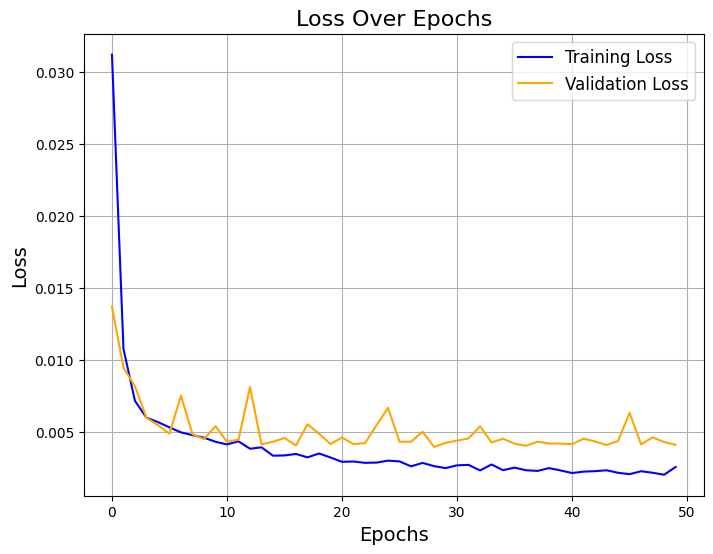

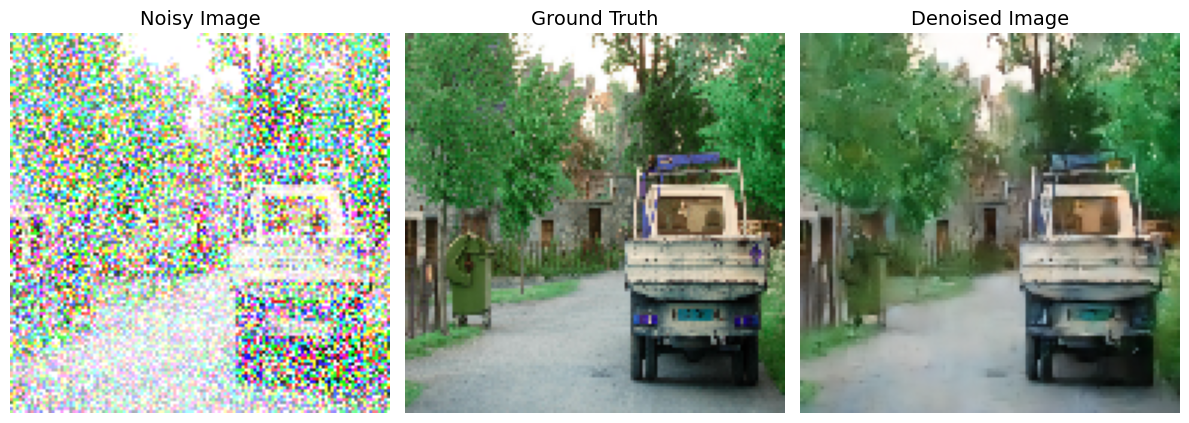

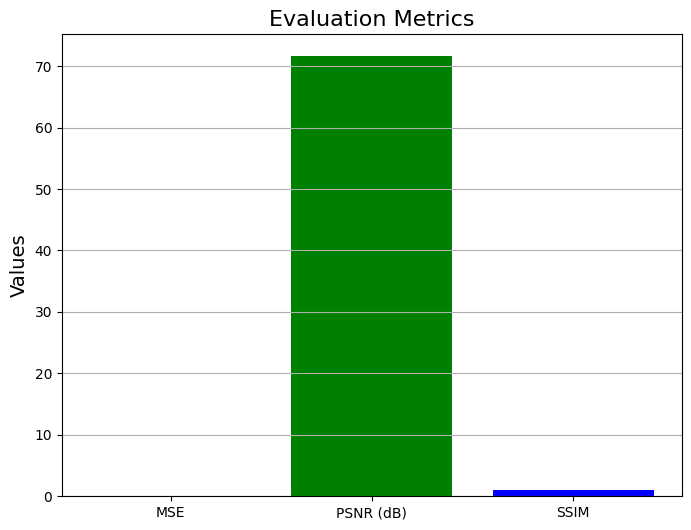

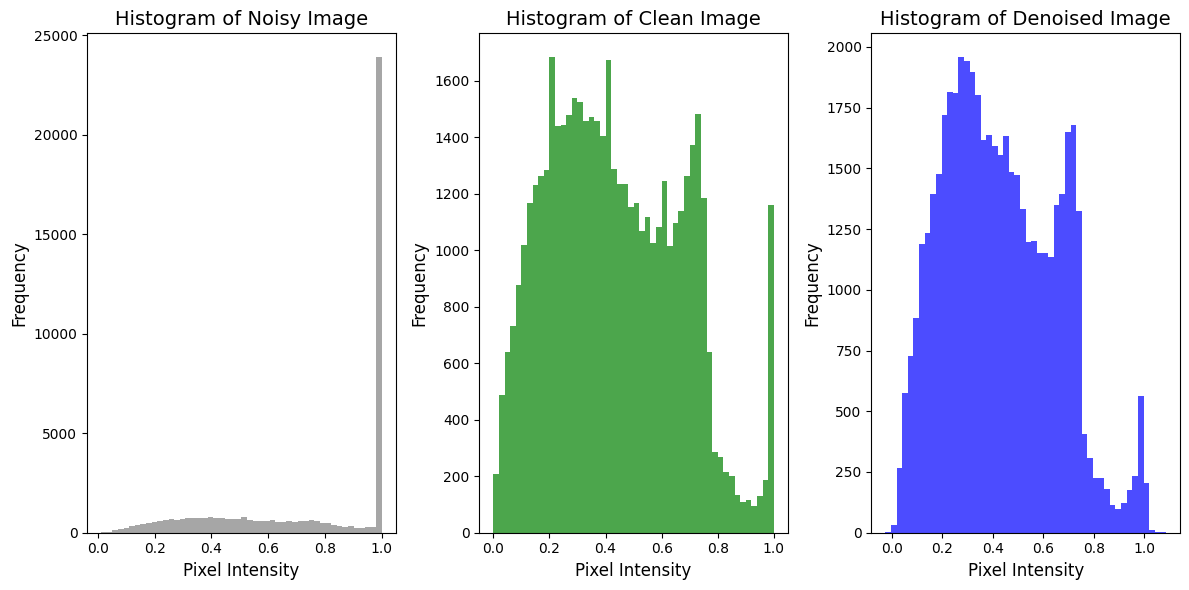

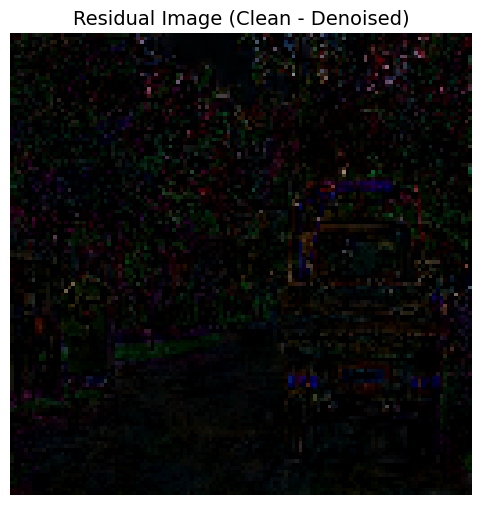

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 238ms/step


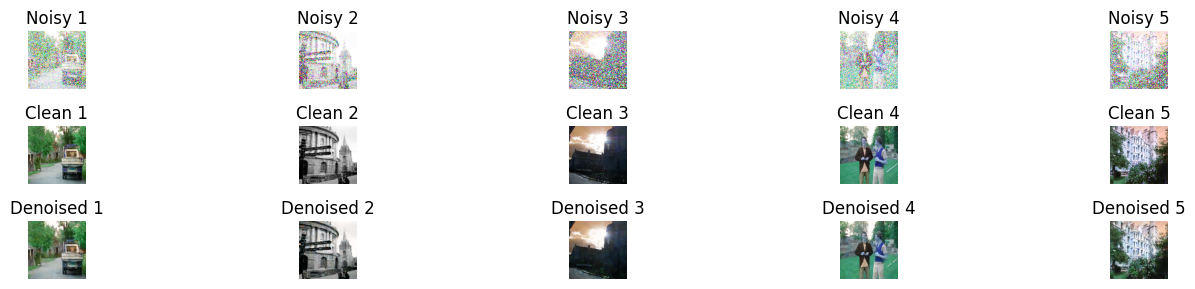

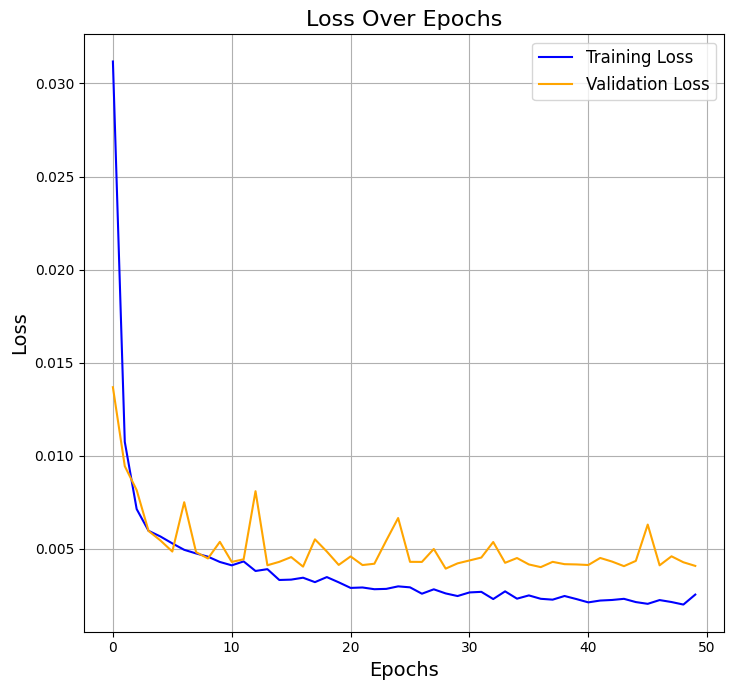

In [21]:
# 1. Histogram of Pixel Intensities (Before and After Denoising)
def plot_histogram(noisy_image, clean_image, denoised_image):
    """Plot histogram of pixel intensities for noisy, clean, and denoised images."""
    plt.figure(figsize=(12, 6))

    plt.subplot(1, 3, 1)
    plt.hist(noisy_image.flatten(), bins=50, color='gray', alpha=0.7)
    plt.title('Histogram of Noisy Image', fontsize=14)
    plt.xlabel('Pixel Intensity', fontsize=12)
    plt.ylabel('Frequency', fontsize=12)

    plt.subplot(1, 3, 2)
    plt.hist(clean_image.flatten(), bins=50, color='green', alpha=0.7)
    plt.title('Histogram of Clean Image', fontsize=14)
    plt.xlabel('Pixel Intensity', fontsize=12)
    plt.ylabel('Frequency', fontsize=12)

    plt.subplot(1, 3, 3)
    plt.hist(denoised_image.flatten(), bins=50, color='blue', alpha=0.7)
    plt.title('Histogram of Denoised Image', fontsize=14)
    plt.xlabel('Pixel Intensity', fontsize=12)
    plt.ylabel('Frequency', fontsize=12)

    plt.tight_layout()
    plt.show()

# 2. Residual Image (Difference between Clean and Denoised Images)
def plot_residual(clean_image, denoised_image):
    """Plot the residual (difference) between clean and denoised images."""
    residual = clean_image - denoised_image
    plt.figure(figsize=(6, 6))
    plt.imshow(residual, cmap='hot')
    plt.title('Residual Image (Clean - Denoised)', fontsize=14)
    plt.axis('off')
    plt.show()

# 3. Batch Denoising Visualization
def plot_batch_denoising(noisy_images, clean_images, denoised_images, batch_size=5):
    """Plot multiple noisy and denoised images for a batch."""
    plt.figure(figsize=(15, 3))

    for i in range(batch_size):
        # Noisy Images
        plt.subplot(3, batch_size, i+1)
        plt.imshow(noisy_images[i], cmap='gray')
        plt.title(f'Noisy {i+1}', fontsize=12)
        plt.axis('off')

        # Clean Images (Ground Truth)
        plt.subplot(3, batch_size, batch_size+i+1)
        plt.imshow(clean_images[i], cmap='gray')
        plt.title(f'Clean {i+1}', fontsize=12)
        plt.axis('off')

        # Denoised Images
        plt.subplot(3, batch_size, 2*batch_size+i+1)
        plt.imshow(denoised_images[i], cmap='gray')
        plt.title(f'Denoised {i+1}', fontsize=12)
        plt.axis('off')

    plt.tight_layout()
    plt.show()

# 4. Learning Curves (Accuracy & Loss Over Epochs)
def plot_learning_curves(history):
    """Plot both Training & Validation Loss and Accuracy over epochs"""
    plt.figure(figsize=(14, 7))

    # Loss
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss', color='blue')
    plt.plot(history.history['val_loss'], label='Validation Loss', color='orange')
    plt.title('Loss Over Epochs', fontsize=16)
    plt.xlabel('Epochs', fontsize=14)
    plt.ylabel('Loss', fontsize=14)
    plt.legend(fontsize=12)
    plt.grid(True)

    # Accuracy (if available)
    if 'accuracy' in history.history:
        plt.subplot(1, 2, 2)
        plt.plot(history.history['accuracy'], label='Training Accuracy', color='green')
        plt.plot(history.history['val_accuracy'], label='Validation Accuracy', color='red')
        plt.title('Accuracy Over Epochs', fontsize=16)
        plt.xlabel('Epochs', fontsize=14)
        plt.ylabel('Accuracy', fontsize=14)
        plt.legend(fontsize=12)
        plt.grid(True)

    plt.tight_layout()
    plt.show()

# Example usage
# Assuming you have a sample noisy image and its corresponding clean image
sample_noisy_image = X_val[0]  # Replace with your noisy test image
sample_clean_image = y_val[0]  # Replace with your clean test image (ground truth)

# Denoise the sample noisy image
denoised_image = dncnn.predict(np.expand_dims(sample_noisy_image, axis=0))[0]

# Calculate metrics
mse_value = calculate_mse(sample_clean_image, denoised_image)
psnr_value = calculate_psnr(sample_clean_image, denoised_image, data_range=255)
ssim_value = calculate_ssim(sample_clean_image, denoised_image, win_size=3, data_range=255)

# Print metrics
print(f'Mean Squared Error (MSE): {mse_value:.4f}')
print(f'Peak Signal-to-Noise Ratio (PSNR): {psnr_value:.4f} dB')
print(f'Structural Similarity Index (SSIM): {ssim_value:.4f}')

# Plot Loss Curves
plot_loss(history)

# Visualize Results
plot_denoising_results(sample_noisy_image, sample_clean_image, denoised_image)

# Plot Evaluation Metrics
plot_metrics(mse_value, psnr_value, ssim_value)

# Plot Histogram of Pixel Intensities
plot_histogram(sample_noisy_image, sample_clean_image, denoised_image)

# Plot Residual Image
plot_residual(sample_clean_image, denoised_image)

# Batch Denoising Visualization (example with batch_size = 5)
plot_batch_denoising(X_val[:5], y_val[:5], dncnn.predict(X_val[:5]))

# Plot Learning Curves
plot_learning_curves(history)
